In [ ]:
! pip install quandl

In [13]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import quandl
import scipy.optimize as sco
import warnings
warnings.filterwarnings("ignore", message="The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version.")
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 1 - MPT and stock data intuition

In [14]:
quandl.ApiConfig.api_key = 'WefMPUFM-JMs2V3QAwgb'
stocks = ['AAPL','AMZN','FB']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2016-1-1', 'lte': '2017-12-31' }, paginate=True)
data.head()

,date,ticker,adj_close
None,,,
0,2017-12-29,FB,176.46
1,2017-12-28,FB,177.92
2,2017-12-27,FB,177.62
3,2017-12-26,FB,175.99
4,2017-12-22,FB,177.20


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1504 entries, 0 to 1503
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       1504 non-null   datetime64[ns]
 1   ticker     1504 non-null   object        
 2   adj_close  1504 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 35.4+ KB


In [16]:
df = data.set_index('date')
table = df.pivot(columns='ticker')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
table.columns = [col[1] for col in table.columns]
table.head()

,AAPL,AMZN,FB
date,,,
2016-01-04,101.783763,636.99,102.22
2016-01-05,99.233131,633.79,102.73
2016-01-06,97.291172,632.65,102.97
2016-01-07,93.185040,607.94,97.92
2016-01-08,93.677776,607.05,97.33


Text(0, 0.5, 'price in $')

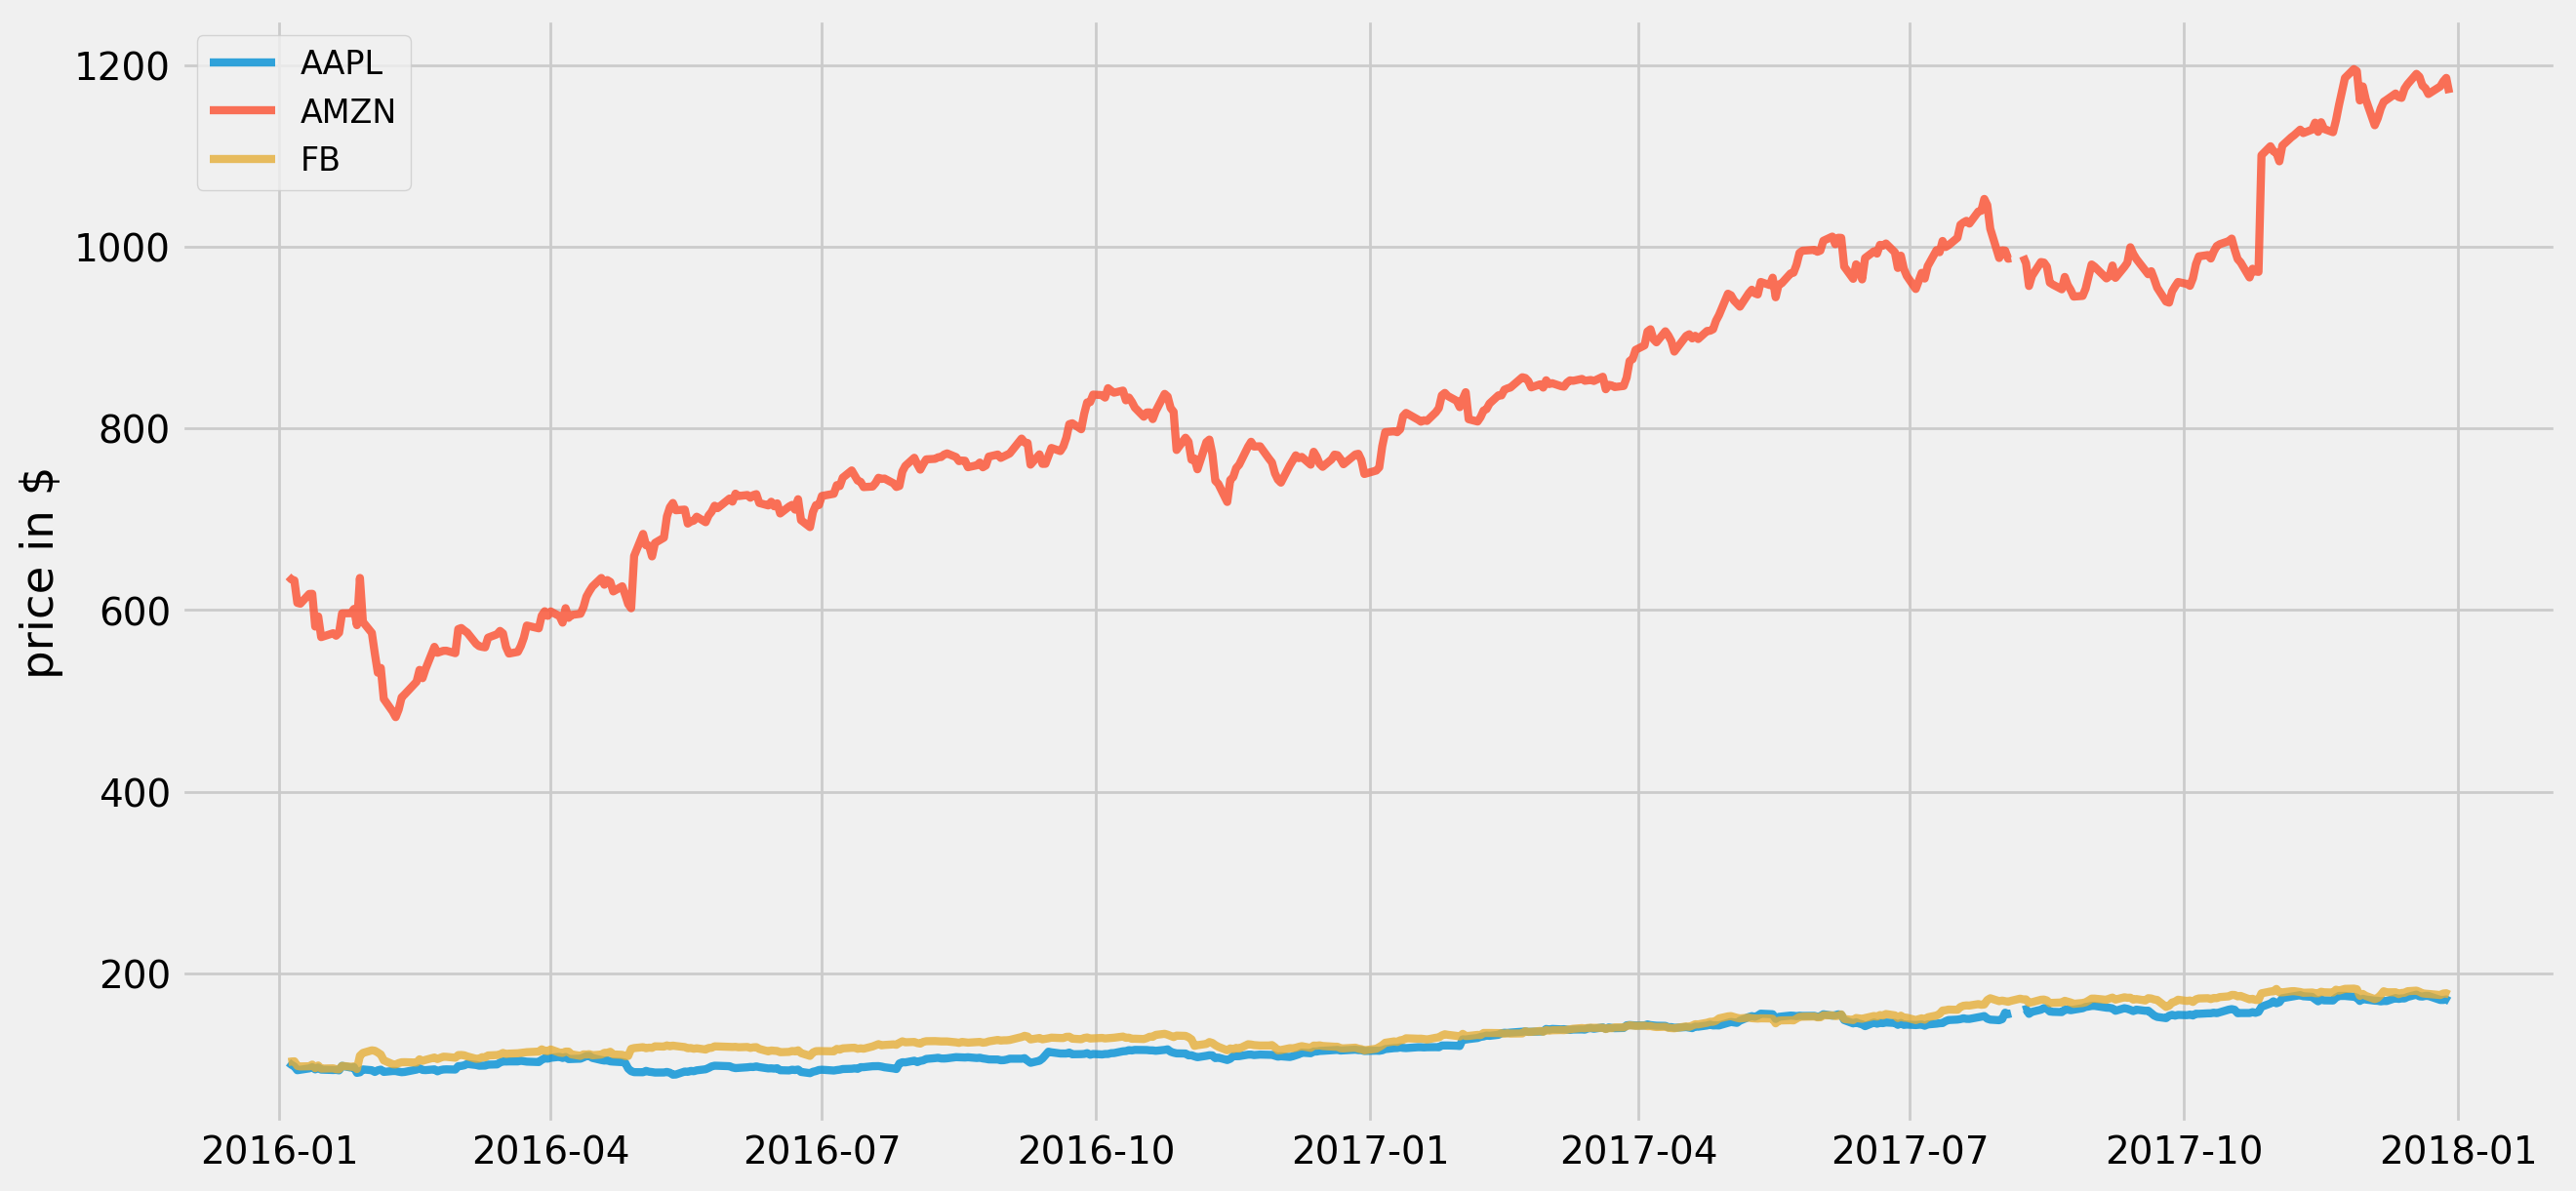

In [17]:
plt.figure(figsize=(14, 7))
for c in table.columns.values:
    plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper left', fontsize=12)
plt.ylabel('price in $')

Percentage Change on daily data

Text(0, 0.5, 'daily returns')

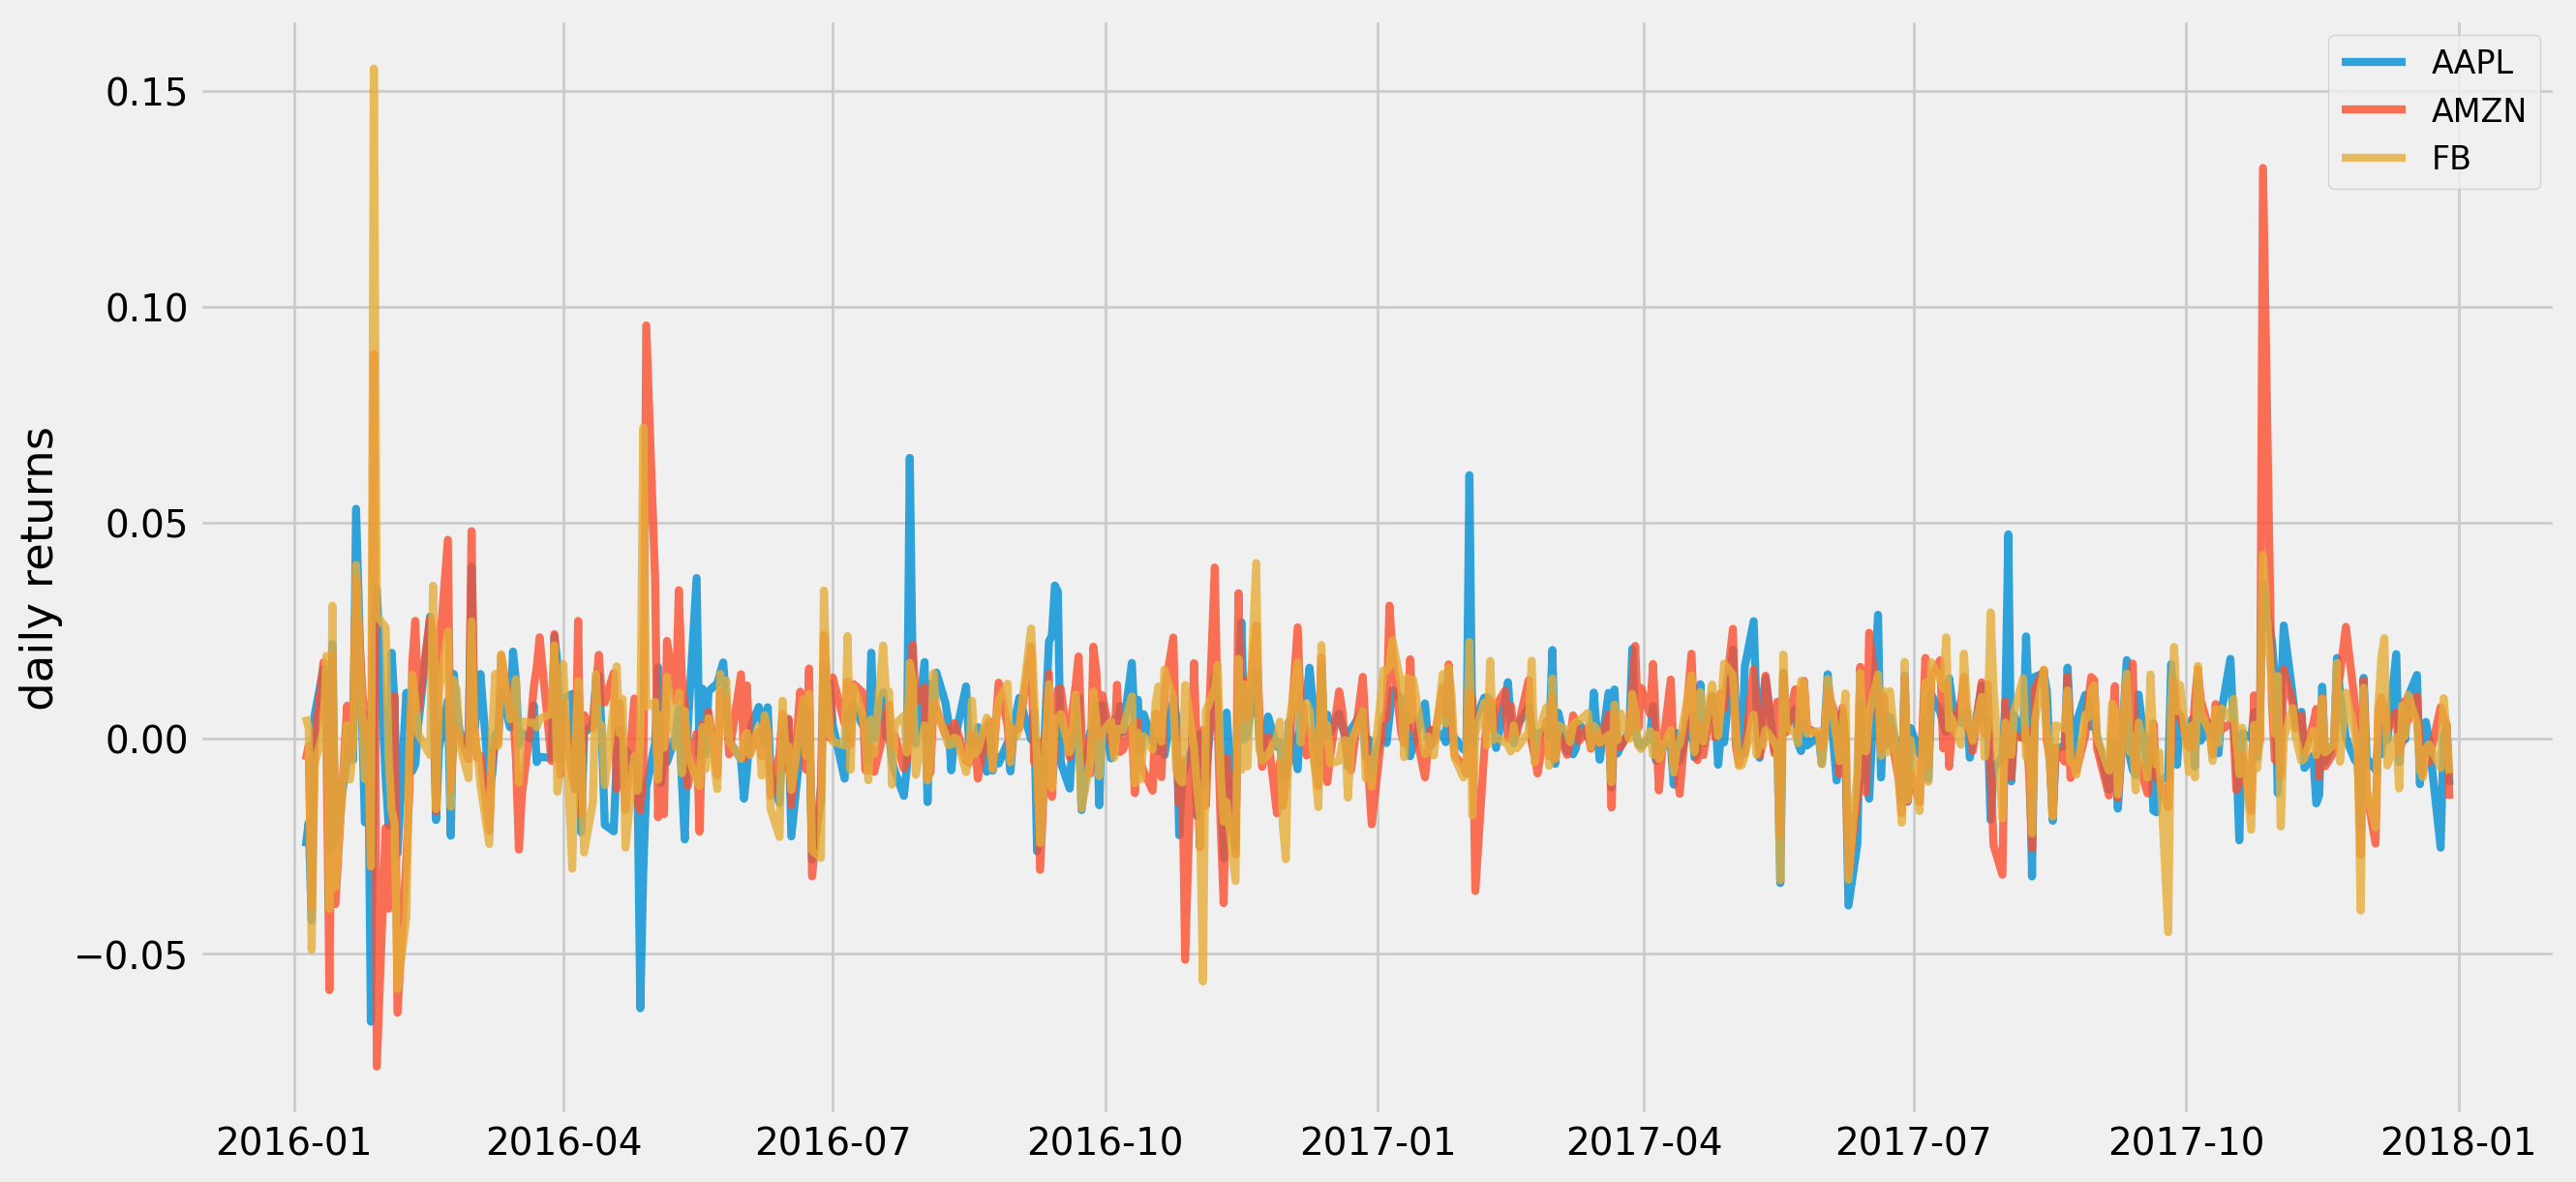

In [18]:
returns = table.pct_change()
plt.figure(figsize=(14, 7))
for c in returns.columns.values:
    plt.plot(returns.index, returns[c], lw=3, alpha=0.8,label=c)
plt.legend(loc='upper right', fontsize=12)
plt.ylabel('daily returns')

In [19]:
returns.head()

,AAPL,AMZN,FB
date,,,
2016-01-04,NaN,NaN,NaN
2016-01-05,-0.025059,-0.005024,0.004989
2016-01-06,-0.019570,-0.001799,0.002336
2016-01-07,-0.042205,-0.039058,-0.049043
2016-01-08,0.005288,-0.001464,-0.006025


### 2 - Random portfolio generation and portfolio volatility

**Weights:** It's a number between 0 and 1 and represents the fraction of portfolio being allocated to each stock. All weights summed togather would come to 1.  

In [20]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [21]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix):
    results = np.zeros((2,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(3)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
    return results, weights_record

### 3 - Sharpe ratio for optimum portfolio

In [22]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(3)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        ## Sharpe Ratio
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev   
    return results, weights_record

In [23]:
returns = table.pct_change()
mean_returns = returns.mean()
print("Mean Returns")
print(mean_returns)
cov_matrix = returns.cov()
print("Covariance Matrix")
print(cov_matrix)
num_portfolios = 25000
risk_free_rate = 0.0178

Mean Returns
AAPL    0.001101
AMZN    0.001340
FB      0.001197
dtype: float64
Covariance Matrix
          AAPL      AMZN        FB
AAPL  0.000171  0.000086  0.000079
AMZN  0.000086  0.000256  0.000142
FB    0.000079  0.000142  0.000217


### 4 - Portfolio allocation using sharpe ratio and efficient frontier

In [24]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print("-"*80)
    print("Maximum Sharpe Ratio Portfolio Allocation\n")
    print("Annualised Return:", round(rp,2))
    print("Annualised Volatility:", round(sdp,2))
    print("\n")
    print(max_sharpe_allocation)
    print("-"*80)
    print("Minimum Volatility Portfolio Allocation\n")
    print("Annualised Return:", round(rp_min,2))
    print("Annualised Volatility:", round(sdp_min,2))
    print("\n")
    print(min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.3
Annualised Volatility: 0.18


             AAPL   AMZN     FB
allocation  44.58  29.15  26.26
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.29
Annualised Volatility: 0.18


             AAPL   AMZN     FB
allocation  54.43  15.74  29.83


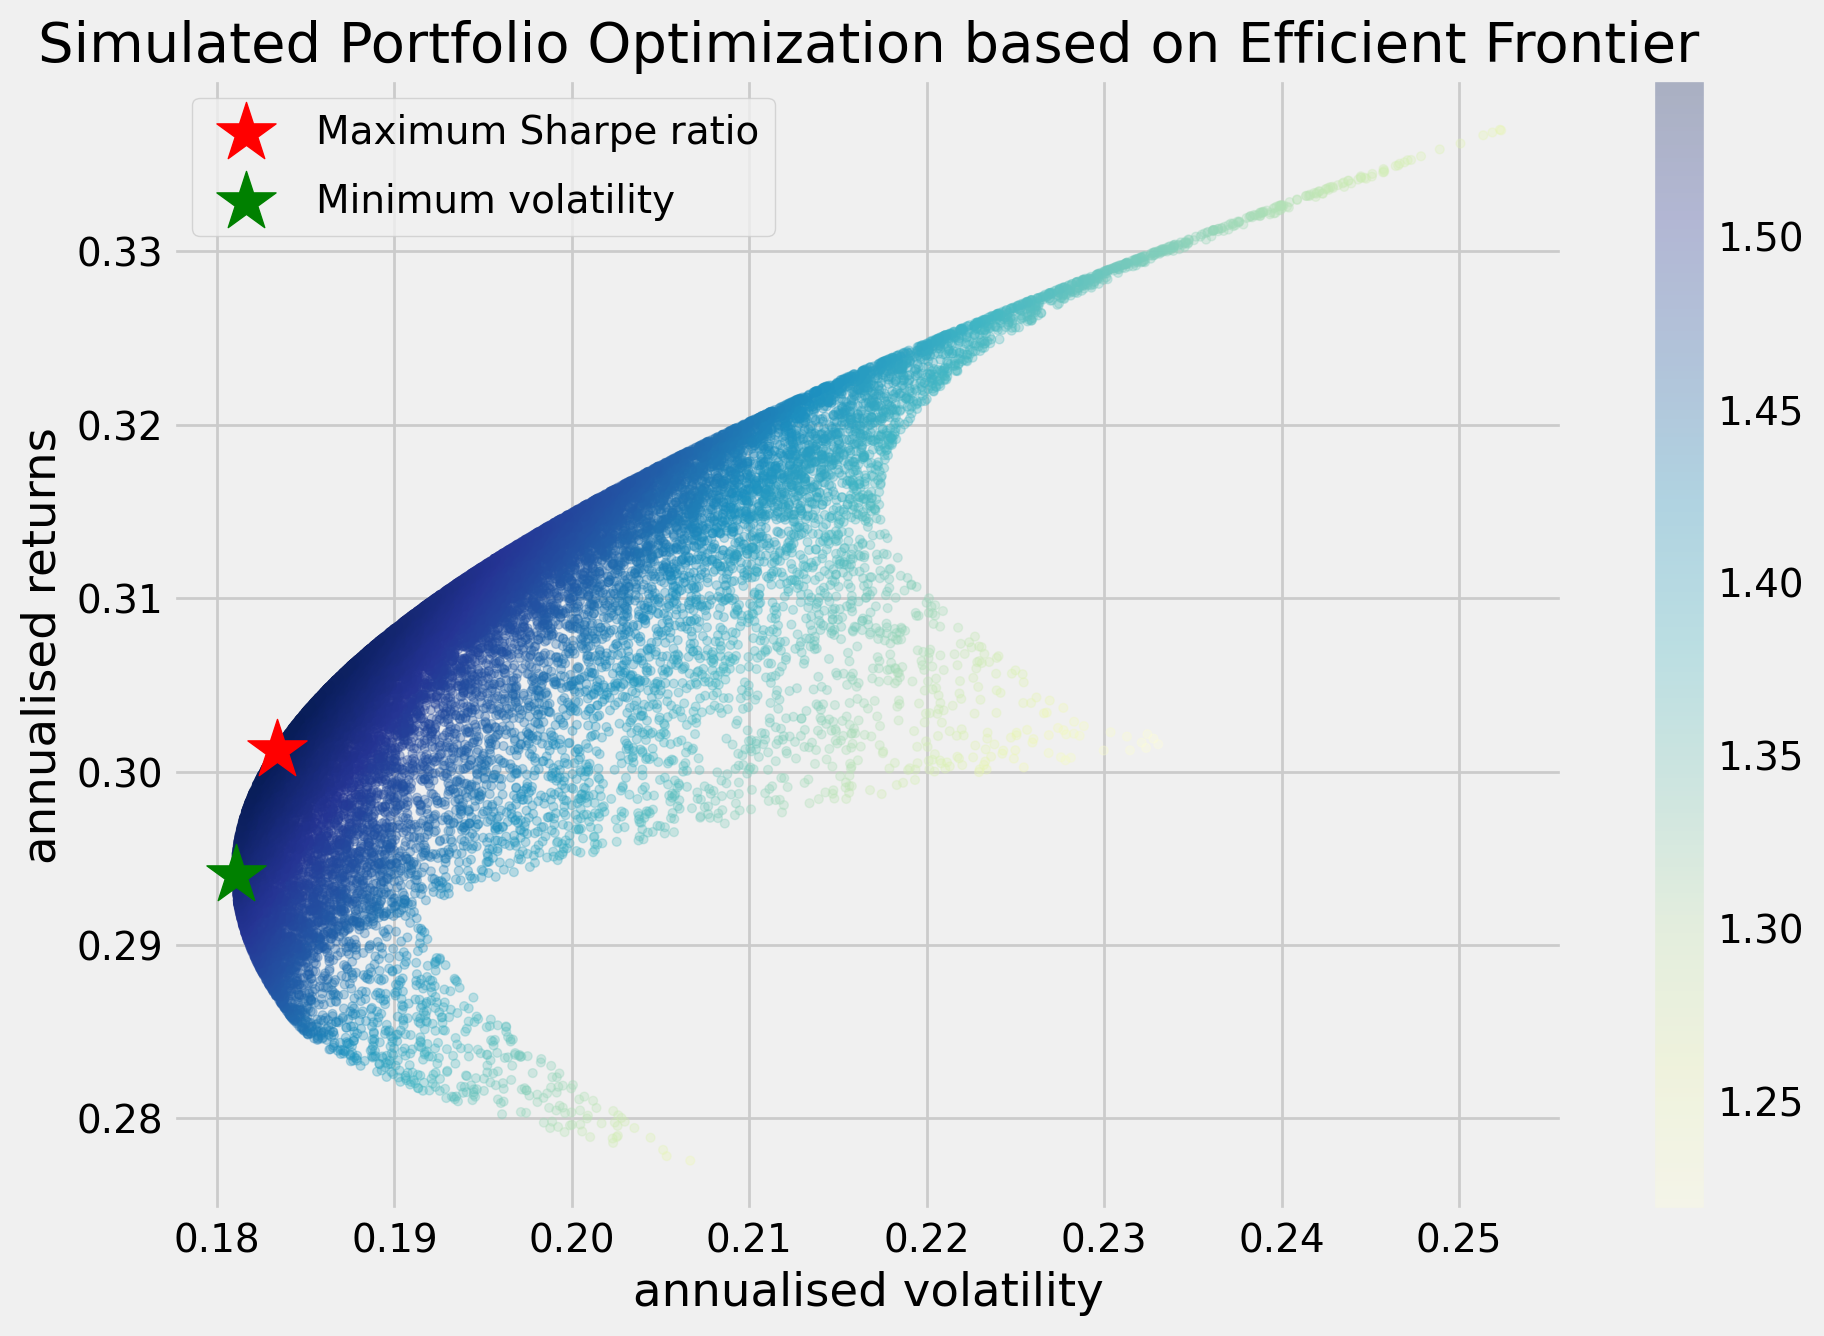

In [25]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

### 5 - Maximize Sharpe ratio with Scipy Optimization

In [26]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

minimize volatility

In [27]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result